In [431]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [432]:
pd.options.display.max_columns = 2000

In [433]:
#Скачиваем данные и их описание
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2017-03-03 10:19:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [text/plain]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K   108KB/s    in 0.7s    

2017-03-03 10:19:58 (108 KB/s) - ‘german.data.1’ saved [79793/79793]

--2017-03-03 10:19:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/msword]
Saving to: ‘german.doc.1’

german.doc.1        100%[===================>]   4.57K  -

In [434]:
#Извлекаем из файлика с описанием названия признаков и значений
import re
names = [] #названия признаков по порядку
converts = [] #словари с названиями значений для каждого признака
with open("german.doc") as f:
    while True:
        l = f.readline()
        if not l:
            break
        l = l.strip()
        if re.match("Attr?ibute \d+", l): #В описании опечатка
            names.append(f.readline().strip())
            converts.append({})
        match = re.match("(A\d+) : (.*)", l)
        if match:
            converts[-1][match.group(1)] = match.group(2)

#Столбцы, которые нужно заменить на наборы бинарных (нелинеаризуемые)
class_features = np.array([4, 9, 10, 14, 15]) - 1

In [435]:
data = pd.read_csv("german.data", ' ', skipinitialspace=True, names=names+["target"])
#В столбцах, которые будем бинаризовать, меняем значения на их описания 
for el in class_features:
    data.replace(converts[el], inplace=True)
#Бинаризуем
data = pd.get_dummies(data, columns=np.array(names)[class_features])
#Линеаризуем оставшиеся строковые столбцы
object_columns = data.select_dtypes(["object"]).columns
for col in object_columns:
    data[col] = data[col].apply(lambda x: int(x[-1]))

In [436]:
data.head()

,Status of existing checking account,Duration in month,Credit history,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Present residence since,Property,Age in years,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,target,Purpose_business,Purpose_car (new),Purpose_car (used),Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_others,Purpose_radio/television,Purpose_repairs,Purpose_retraining,Personal status and sex_female : divorced/separated/married,Personal status and sex_male : divorced/separated,Personal status and sex_male : married/widowed,Personal status and sex_male : single,Other debtors / guarantors_co-applicant,Other debtors / guarantors_guarantor,Other debtors / guarantors_none,Other installment plans_bank,Other installment plans_none,Other installment plans_stores,Housing_for free,Housing_own,Housing_rent
0,1,6,4,1169,5,5,4,4,1,67,2,3,1,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
1,2,48,2,5951,1,3,2,2,1,22,1,3,1,1,1,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0
2,4,12,4,2096,1,4,2,3,1,49,1,2,2,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
3,1,42,2,7882,1,4,2,4,2,45,1,3,2,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
4,1,24,3,4870,1,3,3,4,4,53,2,3,2,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0


In [437]:
#Обучаем модель. В описании репозитория рекомендуют давать больший вес плохим кредитам.
#Остальные параметры подгонял на глаз,чтобы разбиение выглядело разумно.
model = tree.DecisionTreeClassifier(min_samples_split=0.1, min_samples_leaf=0.01, min_impurity_split=0.27, random_state=57, class_weight={1: 1, 2: 5})
model.fit(data.drop("target", 1), data.target)

DecisionTreeClassifier(class_weight={1: 1, 2: 5}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=0.27, min_samples_leaf=0.01,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=57, splitter='best')

In [438]:
dot_data = tree.export_graphviz(model, out_file="small_tree.out",
                         feature_names=data.columns,  
                         class_names=["good", "bad"],
                         filled=True, rounded=True,  
                         special_characters=False)  

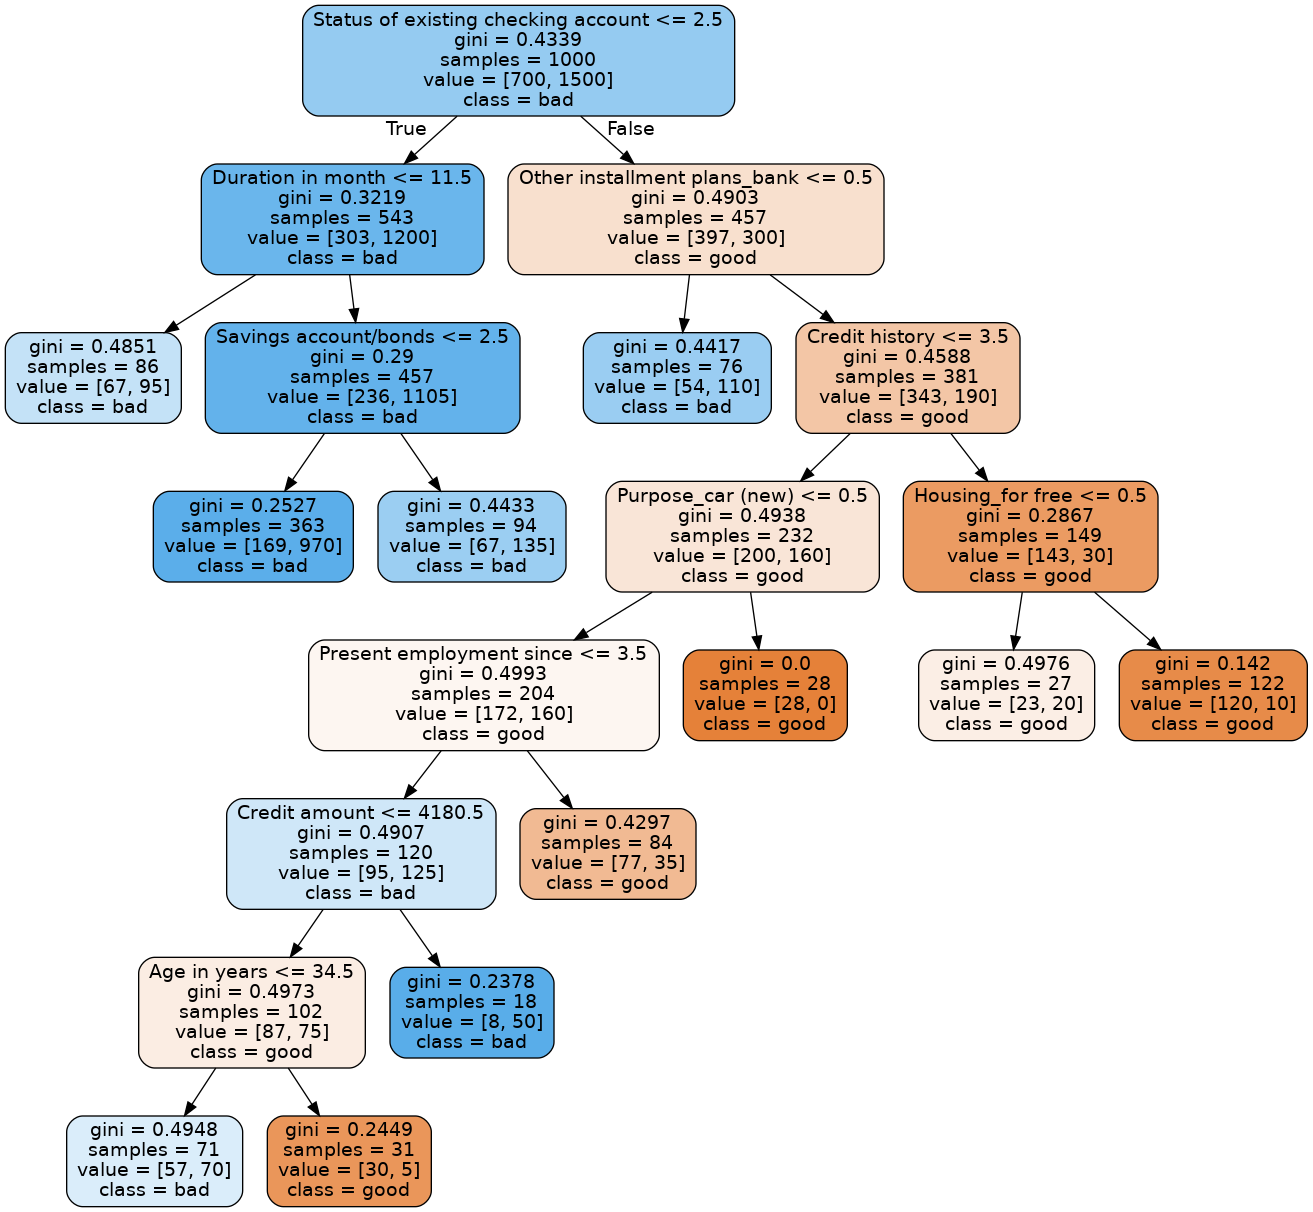

In [439]:
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())  

В первую очередь спрашиваем, много ли денег на счету, и если много, то скорее даем, а если мало - не даем. В правой ветке спрашиваем, есть ли счета в другом банке (обязательно нужны) и другие кредиты (лучше, если есть). Если кредитов нет, то даем либо если на новую машину, либо если давно работает, либо не очень много даем зрелому клиенту.

In [440]:
train = data.drop("target", 1)
target = data.target

In [441]:
from sklearn.model_selection import cross_val_score

In [442]:
from matplotlib import pyplot as plt
%matplotlib inline

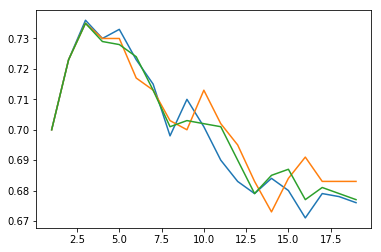

In [443]:
#Кросс-валидация
for rand in [57, 228, 310]: #Построим несколько разных деревьев
    train = data.drop("target", 1)
    target = data.target
    depths = np.arange(1, 20)
    score = [np.mean(cross_val_score(tree.DecisionTreeClassifier(max_depth=depth, random_state=rand), train, target)) for depth in depths]
    plt.plot(depths, score)

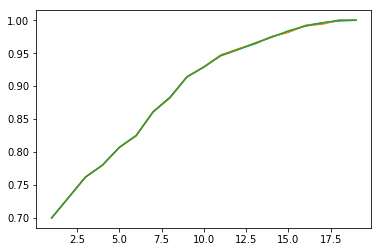

In [444]:
#Тестируем на обучении
for rand in [57, 228, 310]:
    train = data.drop("target", 1)
    target = data.target
    depths = np.arange(1, 20)
    score = []
    for depth in depths:
        model = tree.DecisionTreeClassifier(max_depth=depth, random_state=rand)
        model.fit(train, target)
        score.append(accuracy_score(model.predict(train), target))
    plt.plot(depths, score)

На кросс-валидации видно, что оптимальная глубина равна 3, а дальше начинается переобучение. При тестировании на обучающей выборке качество закономерно растет до 100%.